In [1]:
!wget -q https://www.dropbox.com/s/ugajb9vwqqjpmo4/MT_RCAN.zip
!unzip -q MT_RCAN.zip
!rm MT_RCAN.zip

!wget -q https://www.dropbox.com/s/4xhnxri2rd25lc6/MT_WGAN.zip
!unzip -q MT_WGAN.zip
!rm MT_WGAN.zip

!wget -q https://www.dropbox.com/s/moeooo0lgnogcyv/MT.zip
!unzip -q MT.zip
!rm MT.zip

In [2]:
from skimage.metrics import structural_similarity as ssim
from skimage import io
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

def normalize(img):
  return (img - img.min()) / (img.max() - img.min() + 1e-10)

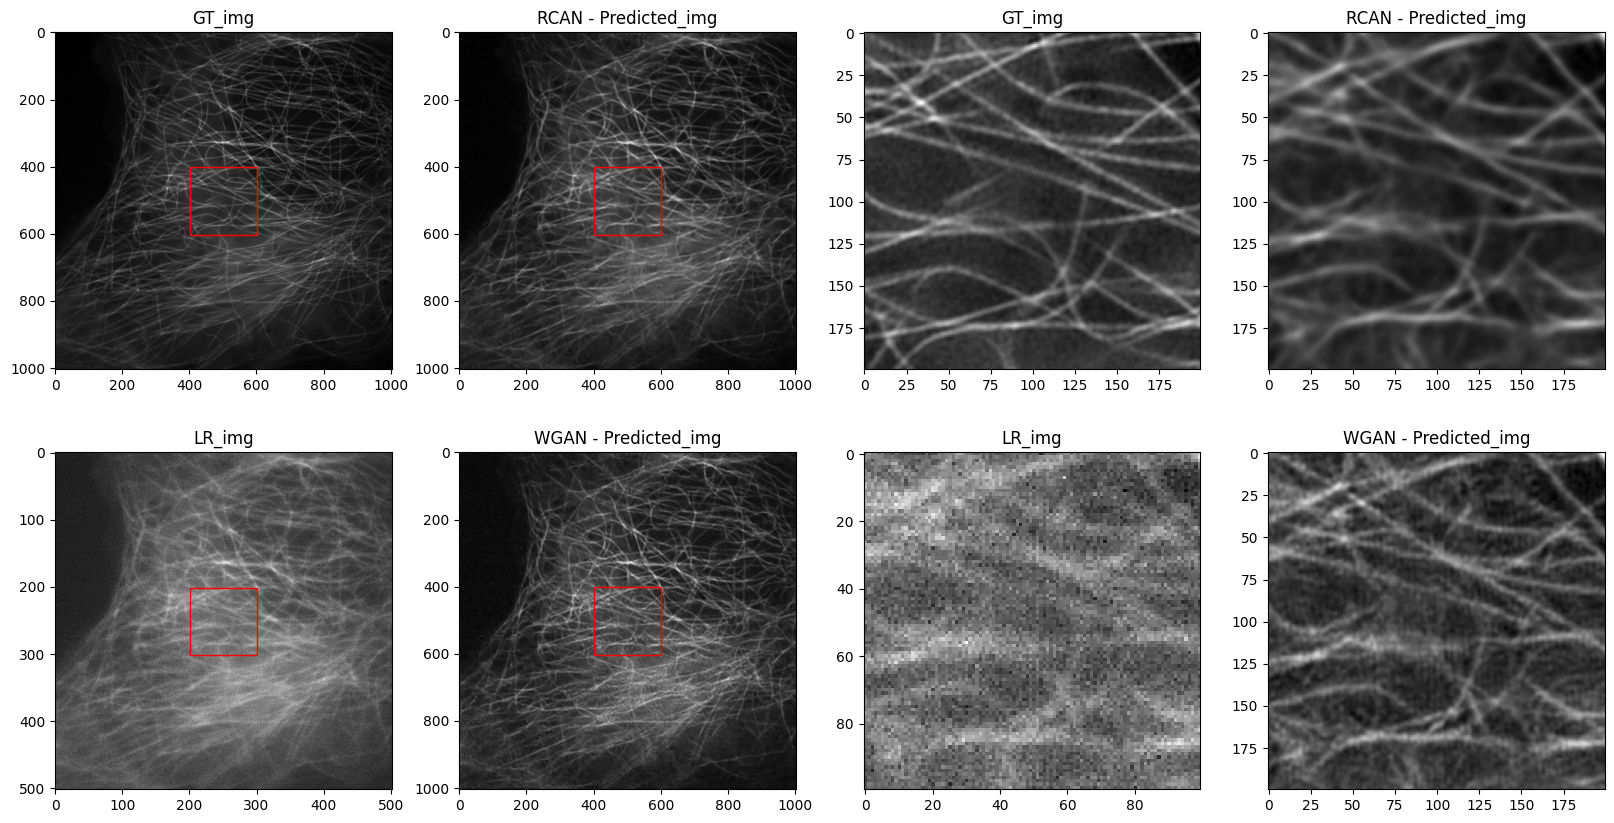

In [3]:
rcan_path = '/content/MT_RCAN/001.tif'
wgan_path = '/content/MT_WGAN/001.tif'
gt_img_path = '/content/MT/test/test_gt/001.tif'
wf_img_path = '/content/MT/test/test_wf/level_01/001.tif'

rcan_result = normalize(io.imread(rcan_path))
wgan_result = normalize(io.imread(wgan_path))
gt_img = normalize(io.imread(gt_img_path))
wf_img = normalize(io.imread(wf_img_path))

zoom_size = 100
center_point = None
scale = gt_img.shape[0] // wf_img.shape[0]

plt.figure(figsize=(20,10))

gt_center_point = center_point if center_point is not None else (gt_img.shape[0]//2, gt_img.shape[1]//2)
wt_center_point = (gt_center_point[0]//scale, gt_center_point[1]//scale)
wf_zoom_size = zoom_size // scale

plt.subplot(2,4,1)
plt.imshow(gt_img, 'gray')
plt.title('GT_img')
ax = plt.gca()
ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                        linewidth=1,edgecolor='r',facecolor='none'))
plt.subplot(2,4,2)
plt.imshow(rcan_result, 'gray')
plt.title('RCAN - Predicted_img')
ax = plt.gca()
ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                        linewidth=1,edgecolor='r',facecolor='none'))
plt.subplot(2,4,3)
plt.title('GT_img')
plt.imshow(gt_img[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                  gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')

plt.subplot(2,4,4)
plt.imshow(rcan_result[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                  gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
plt.title('RCAN - Predicted_img')

plt.subplot(2,4,5)
plt.imshow(wf_img, 'gray')
plt.title('LR_img')
ax = plt.gca()
ax.add_patch(Rectangle((wt_center_point[0]-wf_zoom_size, wt_center_point[1]-wf_zoom_size),
                        wf_zoom_size*2,wf_zoom_size*2,
                        linewidth=1,edgecolor='r',facecolor='none'))
plt.subplot(2,4,6)
plt.imshow(wgan_result, 'gray')
plt.title('WGAN - Predicted_img')
ax = plt.gca()
ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                        linewidth=1,edgecolor='r',facecolor='none'))

plt.subplot(2,4,7)
plt.imshow(wf_img[wt_center_point[0]-wf_zoom_size:wt_center_point[0]+wf_zoom_size,
                  wt_center_point[1]-wf_zoom_size:wt_center_point[1]+wf_zoom_size], 'gray')
plt.title('LR_img')

plt.subplot(2,4,8)
plt.imshow(wgan_result[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                  gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
plt.title('WGAN - Predicted_img')

plt.show()

In [4]:
import numpy as np
print(f'GT - mean intensity value: {np.mean(gt_img)}')
print(f'RCAN - mean intensity value: {np.mean(rcan_result)}')
print(f'WGAN - mean intensity value: {np.mean(wgan_result)}')

GT - mean intensity value: 0.14621166476983655
RCAN - mean intensity value: 0.18463836241621046
WGAN - mean intensity value: 0.21278603654275385


So the SSIM values for these images would be:

In [5]:
rcan_ssim = ssim(gt_img, rcan_result)
wgan_ssim = ssim(gt_img, wgan_result)

print(f'SSIM RCAN: {rcan_ssim}')
print(f'SSIM WGAN: {wgan_ssim}')

SSIM RCAN: 0.8115268177291736
SSIM WGAN: 0.68655251730591


The problem is that SSIM depens on the window size that is used to obtain its values:

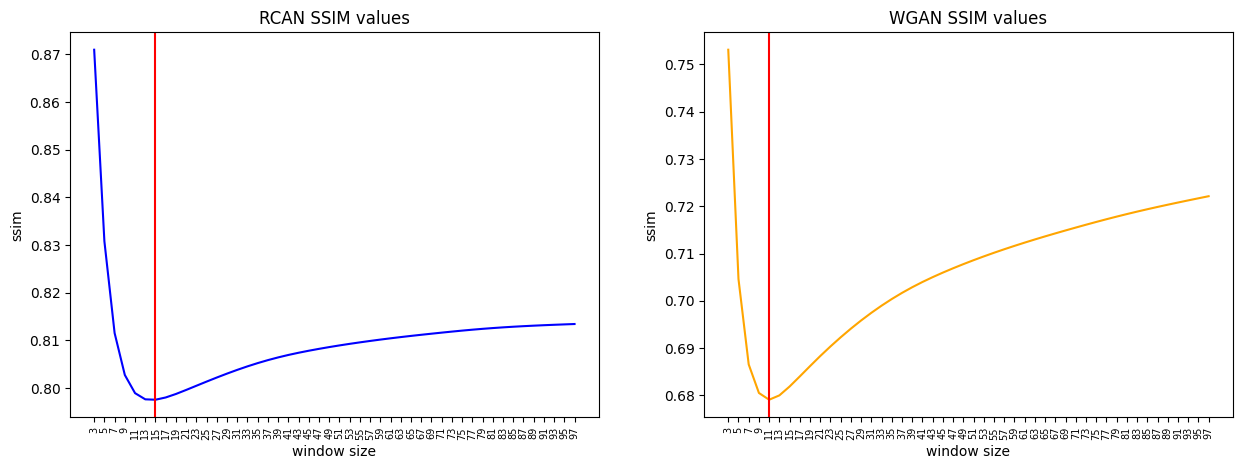

In [6]:
rcan_ssim_list = []
wgan_ssim_list = []

min_rcan_ssim = 1
min_rcan_win_size = None
min_wgan_ssim = 1
min_wgan_win_size = None

max_win_size = 99

for i, win_size in enumerate(range(3,max_win_size,2)):

  rcan_ssim = ssim(gt_img, rcan_result, win_size=win_size)
  wgan_ssim = ssim(gt_img, wgan_result, win_size=win_size)

  rcan_ssim_list.append(rcan_ssim)
  wgan_ssim_list.append(wgan_ssim)

  if rcan_ssim < min_rcan_ssim:
    min_rcan_ssim = rcan_ssim
    min_rcan_win_size = i

  if wgan_ssim < min_wgan_ssim:
    min_wgan_ssim = wgan_ssim
    min_wgan_win_size = i

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('RCAN SSIM values')
plt.xlabel('window size')
plt.ylabel('ssim')
plt.xticks(range(len(rcan_ssim_list)),range(3,max_win_size,2), rotation=90, fontsize=7)
plt.plot(rcan_ssim_list, color='b')
plt.axvline(x = min_rcan_win_size, color='r')

plt.subplot(1,2,2)
plt.title('WGAN SSIM values')
plt.xlabel('window size')
plt.ylabel('ssim')
plt.xticks(range(len(rcan_ssim_list)), range(3,max_win_size,2),rotation=90, fontsize=7)
plt.plot(wgan_ssim_list, color='orange')
plt.axvline(x = min_wgan_win_size, color='r')

plt.show();


If we increase the win_size to the size of the images, this will be the differences between them

In [7]:
rcan_ssim_list = []
wgan_ssim_list = []

min_rcan_ssim = 1
min_rcan_win_size = None
min_wgan_ssim = 1
min_wgan_win_size = None

max_win_size = 1004

for i, win_size in enumerate(range(3,max_win_size,2)):

  rcan_ssim = ssim(gt_img, rcan_result, win_size=win_size)
  wgan_ssim = ssim(gt_img, wgan_result, win_size=win_size)

  rcan_ssim_list.append(rcan_ssim)
  wgan_ssim_list.append(wgan_ssim)

  if rcan_ssim < min_rcan_ssim:
    min_rcan_ssim = rcan_ssim
    min_rcan_win_size = i

  if wgan_ssim < min_wgan_ssim:
    min_wgan_ssim = wgan_ssim
    min_wgan_win_size = i


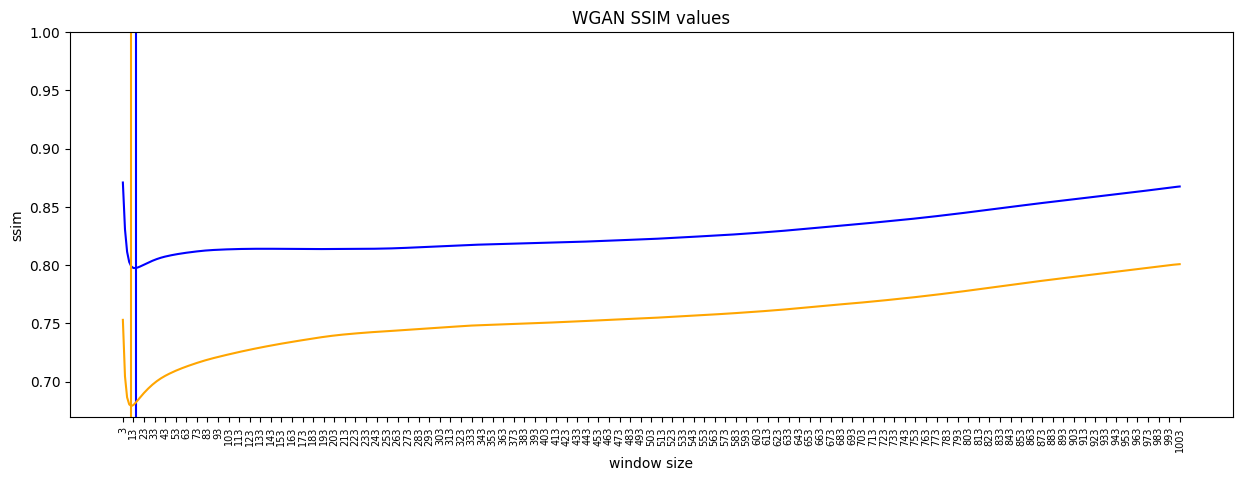

In [8]:
plt.figure(figsize=(15,5))
plt.title('RCAN SSIM values')
plt.xlabel('window size')
plt.ylabel('ssim')
plt.xticks(range(0,len(rcan_ssim_list),5),range(3,max_win_size,10), rotation=90, fontsize=7)
plt.plot(rcan_ssim_list, color='b')
plt.axvline(x = min_rcan_win_size, color='b')

plt.title('WGAN SSIM values')
plt.xlabel('window size')
plt.ylabel('ssim')
plt.xticks(range(0,len(rcan_ssim_list),5), range(3,max_win_size,10),rotation=90, fontsize=7)
plt.plot(wgan_ssim_list, color='orange')
plt.axvline(x = min_wgan_win_size, color='orange')

plt.ylim((None, 1))
plt.show();